# Instructions
In *LightBox_annotation.csv* and *NormalRoomLight_annotation.csv*, the file extensions in the file_name column have been changed from .jpg to .JPG

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.transforms import RandomAffine, Resize, ColorJitter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch.optim as optim
import cv2
import torch.nn as nn
from torch.nn.modules import pooling
from torch.nn.modules.flatten import Flatten
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.nn import Parameter
from torch.nn import init
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.transforms import functional as FT
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import timm
import random
import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 20
batch_size = 32

train_root_path = '/content/drive/MyDrive/AAR/seedsegment/train'
test_root_path = '/content/drive/MyDrive/AAR/seedsegment/test'

In [2]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [15]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%cd '/content/drive/MyDrive/AAR/seedsegment'

/content/drive/.shortcut-targets-by-id/1-LnDmAP9fMOscPjFh9ALSz6QzQsBq5Gj/seedsegment


In [6]:
base_dir = "/content/drive/MyDrive"
csv_folder = os.path.join(base_dir, "csv_folder")

if not os.path.exists(csv_folder):
  os.makedirs(csv_folder)

In [7]:
%cd "/content/drive/MyDrive/csv_folder"

/content/drive/MyDrive/csv_folder


In [2]:
list_good_seeds = sorted(os.listdir('/content/drive/MyDrive/AAR/seedsegment/train/GoodSeed'))
list_bad_seeds = sorted(os.listdir('/content/drive/MyDrive/AAR/seedsegment/train/BadSeed'))

# writing to the data.csv file
with open('data.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["image_name", "label"])

  # store good seeds along with their paths
  for filename in list_good_seeds:
    writer.writerow([filename, 1])

  # store bad seeds along with their paths
  for filename in list_bad_seeds:
    writer.writerow([filename, 0])

print("csv file saved!")

csv file saved!


In [3]:
# Split the dataset into training and temporary sets (80/20 split)
data_df = pd.read_csv('data.csv')
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=seed)

# Save the datasets to separate CSV files
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)

In [4]:
class MyDataLoader(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
      self.data = pd.read_csv(csv_file)  # Load CSV
      self.root_dir = root_dir  # Image folder
      self.transform = transform  # Image transformations

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):

    img_name = self.data.iloc[idx, 0]  # Get filename
    label = int(self.data.iloc[idx, 1]) # Get label

    # Determine subfolder based on class label
    subfolder = "GoodSeed" if label == 1 else "BadSeed"
    img_path = os.path.join(self.root_dir, subfolder, img_name)

    image = Image.open(img_path).convert("RGB")
    label = torch.tensor(label, dtype=torch.long)

    if self.transform:
        image = self.transform(image)

    return image, label

In [5]:
# Load Batch-2 and Batch-3 dataset
class LoadTestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row["file_name"]
        x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        label = 1 if row["bbox_label"] == "GOOD" else 0

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Crop image based on bounding box
        image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

def getDataLoader(model_type):
    # Data augmentation for training
    if model_type == "baseline":
        training_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    elif model_type == "improved":
        training_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Load datasets
    train_dataset = MyDataLoader("train.csv", train_root_path, transform=training_transform)
    val_dataset = MyDataLoader("validation.csv", train_root_path, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset1 = LoadTestDataset("/content/drive/MyDrive/csv_folder/NormalRoomLight_annotation.csv", transform=transform)
    test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
    test_dataset2 = LoadTestDataset("/content/drive/MyDrive/csv_folder/LightBox_annotation.csv", transform=transform)
    test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader1, test_loader2, val_dataset, test_dataset1, test_dataset2

# Existing Model (ResNet50)

In [6]:
class ResNet50Classifier(nn.Module):
  def __init__(self, num_classes=2):
    super(ResNet50Classifier, self).__init__()
    self.resnet = models.resnet50(pretrained=True) # Load pretrained ResNet50
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

  def forward(self, x):
    output = self.resnet(x)
    return output

# Proposed Model (Resnet50 with CBAM + ViT)

In [7]:
# Channel Attention Module
class Channel_Attention(nn.Module):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(Channel_Attention, self).__init__()
        self.pool_types = pool_types
        self.shared_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=channel_in, out_features=channel_in//reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=channel_in//reduction_ratio, out_features=channel_in)
        )

    def forward(self, x):
        channel_attentions = []
        for pool_types in self.pool_types:
            if pool_types == 'avg':
                pool_init = nn.AvgPool2d(kernel_size=(x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                avg_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_types == 'max':
                pool_init = nn.MaxPool2d(kernel_size=(x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                max_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = torch.stack(channel_attentions, dim=0).sum(dim=0)
        scaled = nn.Sigmoid()(pooling_sums).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * scaled #return the element-wise multiplication between the input and the result.


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

# Spatial Attention Module
class Spatial_Attention(nn.Module):
    def __init__(self, kernel_size=7):
        super(Spatial_Attention, self).__init__()
        self.compress = ChannelPool()
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, stride=1, dilation=1, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(num_features=1, eps=1e-5, momentum=0.01, affine=True)
        )

    def forward(self, x):
        x_compress = self.compress(x)
        x_output = self.spatial_attention(x_compress)
        scaled = nn.Sigmoid()(x_output)
        return x * scaled

# CBAM combines channel and spatial attention
class CBAM(nn.Module):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = Channel_Attention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)
        if self.spatial:
            self.spatial_attention = Spatial_Attention(kernel_size=7)
        self.feature_maps = None

    def forward(self, x):
        x_out = self.channel_attention(x)
        if self.spatial:
            x_out = self.spatial_attention(x_out)
        self.feature_maps = x_out
        return x_out

class ResNet50Improved(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50Improved, self).__init__()

        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=True)
        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.layer4 = self.resnet.layer4
        self.resnet.fc = nn.Identity()

        # Add CBAM modules to ResNet
        self.resnet.layer3.add_module("cbam", CBAM(channel_in=1024))
        self.resnet.layer4.add_module("cbam", CBAM(channel_in=2048))

        # Load pretrained  ViT
        self.vit = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()
        self.feature_dim = self.vit.embed_dim

        # Freeze other blocks and unfreeze last 2 blocks
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.blocks[-2].parameters():
            param.requires_grad = True

        self.head = nn.Sequential(
            nn.Linear(2048 + self.feature_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    # Extract combined ResNet + ViT features
    def extract_features(self, x):
        B = x.shape[0]
        x_resnet = self.resnet(x)

        # ViT forward pass
        x_vit = self.vit.patch_embed(x)
        cls_token = self.vit.cls_token.expand(B, -1, -1)
        x_vit = torch.cat((cls_token, x_vit), dim=1)
        x_vit = x_vit + self.vit.pos_embed[:, :x_vit.size(1), :]
        x_vit = self.vit.pos_drop(x_vit)

        # Pass through transformer blocks
        for blk in self.vit.blocks:
            x_vit = blk(x_vit)

        x_vit = self.vit.norm(x_vit)
        cls_feature = x_vit[:, 0]  # [CLS] token

        # Combine ResNet and ViT
        combined = torch.cat([x_resnet, cls_feature], dim=1)
        return combined

    def forward(self, x):
        features = self.extract_features(x)
        return self.head(features)

In [8]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
  train_loss,train_correct=0.0,0
  all_preds = []
  all_labels = []
  all_probs = []
  model.train()
  for images, labels in dataloader:
      labels = labels.to(device, dtype=torch.long)
      images = images.to(device, dtype=torch.float)

      output = model(images)
      loss = loss_fn(output, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * images.size(0)
      scores, predictions = torch.max(output.data, 1)
      train_correct += (predictions == labels).sum().item()
      all_preds.extend(predictions.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
      all_probs.extend(torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy())

  # Calculate precision, recall, f1, auc
  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  auc = roc_auc_score(all_labels, all_probs)

  return train_loss,train_correct, precision, recall, f1, auc


def valid_epoch(model,device,dataloader,loss_fn):
  valid_loss, val_correct = 0.0, 0
  all_preds = []
  all_labels = []
  all_probs = []
  model.eval()
  for images, labels in dataloader:
      labels = labels.to(device, dtype=torch.long)
      images = images.to(device, dtype=torch.float)

      output = model(images)
      loss = loss_fn(output, labels)
      valid_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      probs = F.softmax(output, dim=1)[:, 1]
      val_correct+=(predictions == labels).sum().item()
      all_preds.extend(predictions.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
      all_probs.extend(probs.detach().cpu().numpy())

  # Calculate precision, recall, f1, auc
  precision = precision_score(all_labels, all_preds)
  recall = recall_score(all_labels, all_preds)
  f1 = f1_score(all_labels, all_preds)
  auc = roc_auc_score(all_labels, all_probs)

  return valid_loss,val_correct, precision, recall, f1, auc

In [ ]:
def train_model(model_type):
  # Lists to store metrics for each epoch
  trainloss_list,valloss_list,trainacc_list,valacc_list,precision_list,recall_list,f1_list,auc_list=[],[],[],[],[],[],[],[]
  print(f"**********Training**********")
  highest_f1 = 0.0

  # Existing model
  if model_type == "baseline":
    model = ResNet50Classifier(num_classes=2)
    model_name = "resnet50_baseline.pt"
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

  # Proposed model
  if model_type == "improved":
    model = ResNet50Improved(num_classes=2)
    model_name = "resnet50_improved.pt"
    optimizer = optim.Adam([
        {"params": model.resnet.parameters(), "lr": 3e-5},
        {"params": model.vit.parameters(), "lr": 3e-4},
        {"params": model.head.parameters(), "lr": 1e-4}
    ], weight_decay=1e-4)

  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  train_loader, val_loader, _, _, _, _, _= getDataLoader(model_type)

  # Training loop
  for epoch in range(num_epochs):
      train_loss, train_correct, train_precision, train_recall, train_f1, train_auc=train_epoch(model,device,train_loader,criterion,optimizer)
      val_loss, val_correct, val_precision, val_recall, val_f1, val_auc=valid_epoch(model,device,val_loader,criterion)

      # Calculate accuracy and average loss
      train_loss = train_loss / len(train_loader.sampler)
      train_acc = train_correct / len(train_loader.sampler) * 100
      val_loss = val_loss / len(val_loader.sampler)
      val_acc = val_correct / len(val_loader.sampler) * 100

      print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Training Acc: {train_acc:.2f}% | Validation Acc: {val_acc:.2f}% | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f} | AUC: {val_auc:.4f}")

      trainloss_list.append(train_loss)
      valloss_list.append(val_loss)
      trainacc_list.append(train_acc)
      valacc_list.append(val_acc)
      precision_list.append(val_precision)
      recall_list.append(val_recall)
      f1_list.append(val_f1)
      auc_list.append(val_auc)

      # Save model if it has the best F1
      if val_f1 >= highest_f1:
          highest_f1 = val_f1
          torch.save({'model_state_dict': model.state_dict()}, model_name)
          print(f"Best model saved at epoch {epoch+1} with F1 Score: {highest_f1:.4f}")

  # Print overall average metrics
  print(f"\n\nTraining Loss: {np.mean(trainloss_list):.3f} | Validation Loss: {np.mean(valloss_list):.3f} | Training Acc: {np.mean(trainacc_list):.2f}% | Validation Acc: {np.mean(valacc_list):.2f}% | Precision: {np.mean(precision_list):.4f} | Recall: {np.mean(recall_list):.4f} | F1 Score: {np.mean(f1_list):.4f} | AUC: {np.mean(auc_list):.4f}")

In [10]:
def test_model(batch, model_type):
  print(f"**********Testing with Batch {batch}**********")
  # Load existing model
  if model_type == "baseline":
    model = ResNet50Classifier(num_classes=2)
    model_name = "resnet50_baseline.pt"

  # Load proposed model
  if model_type == "improved":
    model = ResNet50Improved(num_classes=2)
    model_name = "resnet50_improved.pt"

  model.to(device)
  checkpoint = torch.load(model_name)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()
  _, _, test_loader1, test_loader2, _, _, _ = getDataLoader(model_type)
  criterion = nn.CrossEntropyLoss()

  # Test on batch-2
  if batch == 2:
    test_loader = test_loader1
  # Test on batch-3
  elif batch == 3:
    test_loader = test_loader2

  test_loss, test_correct, test_precision, test_recall, test_f1, test_auc = valid_epoch(model, device, test_loader, criterion)
  test_loss = test_loss / len(test_loader.sampler) # Calculate test loss
  test_acc = test_correct / len(test_loader.dataset) * 100 # Calculate test accuracy

  print(f"Testing Loss: {test_loss:.2f} | Testing Accuracy: {test_acc:.2f}% | Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f} | AUC: {test_auc:.4f}")

In [11]:
class GradCamViT:
    def __init__(self, model, target):
        self.model = model.eval()  # Set the model to evaluation mode
        self.feature = None  # To store the features from the target layer
        self.gradient = None  # To store the gradients from the target layer
        self.handlers = []  # List to keep track of hooks
        self.target = target  # Target layer for Grad-CAM
        self._get_hook()  # Register hooks to the target layer

    # Hook to get features from the forward pass
    def _get_features_hook(self, module, input, output):
        self.feature = self.reshape_transform(output)

    # Hook to get gradients from the backward pass
    def _get_grads_hook(self, module, input_grad, output_grad):
        self.gradient = self.reshape_transform(output_grad)

        def _store_grad(grad):
            self.gradient = self.reshape_transform(grad)

        output_grad.register_hook(_store_grad)

    # Register forward hooks to the target layer
    def _get_hook(self):
        self.target.register_forward_hook(self._get_features_hook)
        self.target.register_forward_hook(self._get_grads_hook)

    # Function to reshape the tensor for visualization
    def reshape_transform(self, tensor, height=14, width=14):
        result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
        result = result.transpose(2, 3).transpose(1, 2)
        return result

    # Function to compute the Grad-CAM heatmap
    def __call__(self, inputs):
        inputs.requires_grad = True

        self.model.zero_grad()  # Zero the gradients
        output = self.model(inputs)

        # Get the index of the highest score in each sample of the batch
        indices = torch.argmax(output, dim=1)

        heatmaps = []

        for i in range(len(indices)):
            index = indices[i].item()  # Get the target class index for each sample in the batch
            target = output[i][index]  # Get the target score for the class

            target.backward(retain_graph=True)  # Backward pass to compute gradients

            # Get the gradients and features
            gradient = self.gradient[i].cpu().data.numpy()
            weight = np.mean(gradient, axis=(1, 2))
            feature = self.feature[i].cpu().data.numpy()

            # Compute the weighted sum of the features
            cam = feature * weight[:, np.newaxis, np.newaxis]
            cam = np.sum(cam, axis=0)
            cam = np.maximum(cam, 0)

            # Normalize the heatmap
            cam -= np.min(cam)
            cam /= np.max(cam)
            cam = cv2.resize(cam, (224, 224))

            heatmaps.append(cam)

        return heatmaps

def gen_cam(image, mask):
    # Convert to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * (1-mask)), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - 0.5) * heatmap + 0.5 * image
    cam = cam / np.max(cam)

    return np.uint8(255 * cam)

In [12]:
# Generate Grad-CAM heatmap
def grad_cam(model, image, layer):
    cam = GradCAM(model, layer)
    image = image.to(device)
    output = model(image.unsqueeze(0))
    target_class = torch.argmax(output, dim=1).item()
    cam_maps = cam(class_idx=target_class, scores=output)

    cam_map = cam_maps[0]

    cam_map = cam_map.squeeze().cpu().numpy()
    cam_map = np.maximum(cam_map, 0)
    cam_map = cam_map / cam_map.max()

    return cam_map

# Plot Grad-CAM results for ResNet on 4 images
def plot_resnet_gradcam(images, cam_maps, alpha=0.5):
    fig, axes = plt.subplots(1, 4, figsize=(4, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(4):
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)

        cam_map = cam_maps[i]
        cam_map = cv2.resize(cam_map, (image.shape[1], image.shape[0]))
        cam_map = np.uint8(255 * (1 - cam_map))
        heatmap = cv2.applyColorMap(cam_map, cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

        axes[i].imshow(superimposed_img)
        axes[i].axis('off')

    plt.show()

# Plot Grad-CAM results for selected ViT transformer blocks
def plot_vit_gradcam(images):
    model = ResNet50Improved(num_classes=2)
    model.to(device)
    checkpoint = torch.load('resnet50_improved.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    selected_blocks = [0, 3, 7, 11] # Select specific transformer blocks
    inputs = torch.stack(images).to(device, dtype=torch.float)
    subplot_idx = 1
    plt.figure(figsize=(4, 4))

    for block_idx, block in enumerate(model.vit.blocks):
        if block_idx in selected_blocks:
            target_layer = block.norm1
            grad_cam = GradCamViT(model, target_layer)
            masks = grad_cam(inputs)

            for idx, mask in enumerate(masks[:4]):
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])

                img = images[idx].cpu().numpy().transpose((1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)

                result = gen_cam(img, mask)
                plt.subplot(len(selected_blocks), 4, subplot_idx)
                plt.imshow(result)
                plt.title(f"Block {block_idx + 1}")
                plt.axis('off')
                subplot_idx += 1

    plt.tight_layout()
    plt.show()

# Visualise t-SNE of extracted features
def feature_discriminant(model, model_type):
    model.eval()
    features = []
    labels = []

    extracted_features = []

    def hook_fn(module, input, output):
        extracted_features.append(output.detach().cpu())

    # Register hook on avgpool layer
    if model_type == "baseline":
        hook = model.resnet.avgpool.register_forward_hook(hook_fn)

    _, val_loader, _, _, _, _, _ = getDataLoader(model_type)

    with torch.no_grad():
        for images, label in val_loader:
            extracted_features.clear()
            images = images.to(device)
            label = label.to(device)
            if model_type == "baseline":
                _ = model(images)
                feat = extracted_features[0].view(images.size(0), -1)
            if model_type == "improved":
                feat = model.extract_features(images)
            features.append(feat.cpu().numpy())
            labels.append(label.cpu().numpy())

    if model_type == "baseline":
        hook.remove()
    features = np.vstack(features)
    labels = np.hstack(labels)

    # Reduce dimensions with PCA before applying t-SNE
    pca = PCA(n_components=50)
    features_pca = pca.fit_transform(features)
    tsne = TSNE(n_components=2, perplexity=40).fit_transform(features_pca)

    # Plot t-SNE
    plt.figure(figsize=(5, 3))
    scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar(scatter, label="Class (0: Bad, 1: Good)")
    plt.title('t-SNE plot')
    plt.show()

# Show original and Grad-CAM images for different layers
def display_gradcam(images):
    print("Original Images")
    ori_images = []
    for i in range(4):
        ori_img = images[i]
        ori_images.append(ori_img)
    fig, ax = plt.subplots(1, 4, figsize=(4, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(4):
        img = ori_images[i].cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean  # Reverse normalization
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

    layers = {
        "model.layer1": model.resnet.layer1,
        "model.layer2": model.resnet.layer2,
        "model.layer3": model.resnet.layer3,
        "model.layer4": model.resnet.layer4
    }

    # Generate and plot Grad-CAM for each selected layer
    for name, layer in layers.items():
        print(f"Grad-CAM for {name}")
        heatmaps = []
        gradcam_images = []
        for i in range(4):
            image = images[i]
            heatmap = grad_cam(model, image, layer)
            heatmaps.append(heatmap)
            gradcam_images.append(image)
        plot_resnet_gradcam(gradcam_images, heatmaps)


# Perform model analysis under different transformations
def model_analysis(model, model_type):
    model.eval()
    def add_gaussian_noise(img, mean, std):
        img_tensor = ToTensor()(img)
        noise = torch.randn_like(img_tensor) * std + mean  # Generate Gaussian noise
        noisy_img = img_tensor + noise
        noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
        img_pil = ToPILImage()(noisy_img)
        return img_pil

    transformations = {
      "No transformation": lambda x: x,
      "Translation": lambda x: FT.affine(x, 0, (30, 30), 1, 0),
      "Rotation": lambda x: FT.rotate(x, 30),
      "Scaling": lambda x: FT.affine(x, 0, (0, 0), 1.3, 0),
      "Illumination (Increase brightness)": ColorJitter(brightness=(1.3, 1.3), contrast=0, saturation=0, hue=0),
      "Illumination (Decrease brightness)": ColorJitter(brightness=(0.7, 0.7), contrast=0, saturation=0, hue=0),
      "Noise":  lambda img: add_gaussian_noise(img, mean=0.05, std=0.1)
    }

    # Apply each transformation and evaluate model
    for name, transform in transformations.items():
        print(f"{name}:")
        transform_data = transforms.Compose([
            transforms.Resize((224, 224)),
            transform,
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        analysis_dataset = MyDataLoader("validation.csv", train_root_path, transform=transform_data)
        data_loader = DataLoader(analysis_dataset, batch_size=batch_size, shuffle=False)

        # Display Grad-CAM on transformed images
        images = []
        for i in range(4):
            img, _ = analysis_dataset[i]
            images.append(img)
        display_gradcam(images)
        if model_type == "improved":
            plot_vit_gradcam(images)

        criterion = nn.CrossEntropyLoss()
        val_loss, val_correct, val_precision, val_recall, val_f1, val_auc = valid_epoch(model, device, data_loader, criterion)
        val_loss = val_loss / len(data_loader.sampler)
        val_acc = val_correct / len(data_loader.sampler) * 100

        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.2f}% | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f} | AUC: {val_auc:.4f}\n")

# (3) Train the existing model (ResNet50)

In [ ]:
train_model(model_type="baseline")

**********Training**********
Epoch 1/20 | Training Loss: 0.3458 | Validation Loss: 0.2782 | Training Acc: 84.73% | Validation Acc: 92.02% | Precision: 0.8939 | Recall: 0.9620 | F1 Score: 0.9267 | AUC: 0.9703
Best model saved at epoch 1 with F1 Score: 0.9267
Epoch 2/20 | Training Loss: 0.1512 | Validation Loss: 0.1958 | Training Acc: 94.86% | Validation Acc: 93.16% | Precision: 0.9762 | Recall: 0.8913 | F1 Score: 0.9318 | AUC: 0.9898
Best model saved at epoch 2 with F1 Score: 0.9318
Epoch 3/20 | Training Loss: 0.0951 | Validation Loss: 0.1829 | Training Acc: 96.50% | Validation Acc: 94.30% | Precision: 0.9184 | Recall: 0.9783 | F1 Score: 0.9474 | AUC: 0.9874
Best model saved at epoch 3 with F1 Score: 0.9474
Epoch 4/20 | Training Loss: 0.1048 | Validation Loss: 0.0978 | Training Acc: 96.07% | Validation Acc: 96.87% | Precision: 0.9676 | Recall: 0.9728 | F1 Score: 0.9702 | AUC: 0.9943
Best model saved at epoch 4 with F1 Score: 0.9702
Epoch 5/20 | Training Loss: 0.0760 | Validation Loss: 0

# Test the existing model using Batch-2 and Batch-3

In [ ]:
test_model(batch=2, model_type="baseline") # Test on Batch-2
test_model(batch=3, model_type="baseline") # Test on Batch-3

**********Testing with Batch 2**********
Testing Loss: 0.55 | Testing Accuracy: 82.00% | Precision: 0.7424 | Recall: 0.9800 | F1 Score: 0.8448 | AUC: 0.9232
**********Testing with Batch 3**********
Testing Loss: 0.85 | Testing Accuracy: 71.79% | Precision: 0.6587 | Recall: 0.9157 | F1 Score: 0.7663 | AUC: 0.8206


# (4) Perform model analysis using the validation dataset in Batch-1 for the existing model
Grad-CAM visualisation showing the model's focus areas

No transformation:
Original Images


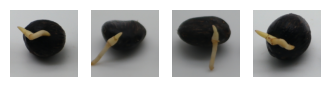

Grad-CAM for model.layer1


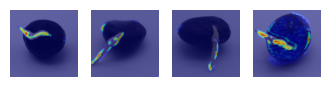

Grad-CAM for model.layer2


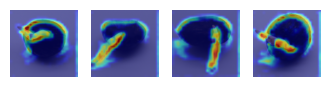

Grad-CAM for model.layer3


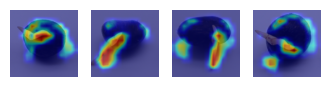

Grad-CAM for model.layer4


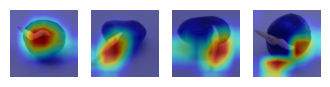

Validation Loss: 0.0978 | Validation Acc: 96.87% | Precision: 0.9676 | Recall: 0.9728 | F1 Score: 0.9702 | AUC: 0.9943

Translation:
Original Images


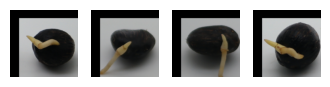

Grad-CAM for model.layer1


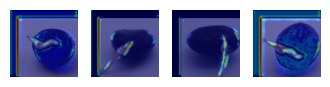

Grad-CAM for model.layer2


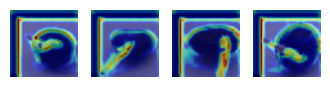

Grad-CAM for model.layer3


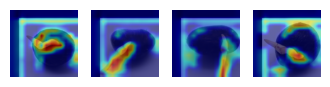

Grad-CAM for model.layer4


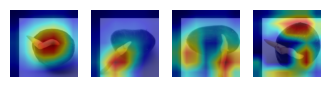

Validation Loss: 0.6997 | Validation Acc: 75.21% | Precision: 0.6790 | Recall: 1.0000 | F1 Score: 0.8088 | AUC: 0.9861

Rotation:
Original Images


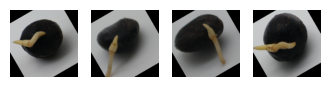

Grad-CAM for model.layer1


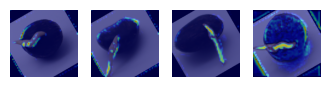

Grad-CAM for model.layer2


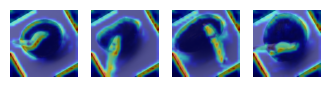

Grad-CAM for model.layer3


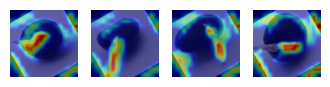

Grad-CAM for model.layer4


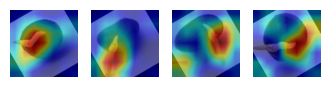

Validation Loss: 0.4515 | Validation Acc: 85.75% | Precision: 0.7863 | Recall: 1.0000 | F1 Score: 0.8804 | AUC: 0.9910

Scaling:
Original Images


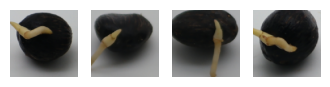

Grad-CAM for model.layer1


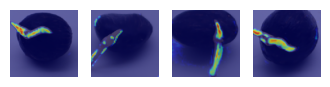

Grad-CAM for model.layer2


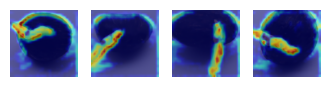

Grad-CAM for model.layer3


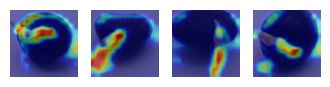

Grad-CAM for model.layer4


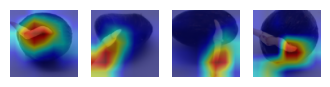

Validation Loss: 0.1250 | Validation Acc: 94.30% | Precision: 0.9316 | Recall: 0.9620 | F1 Score: 0.9465 | AUC: 0.9905

Illumination (Increase brightness):
Original Images


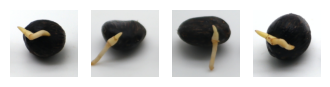

Grad-CAM for model.layer1


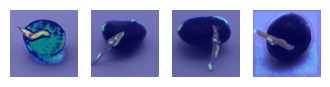

Grad-CAM for model.layer2


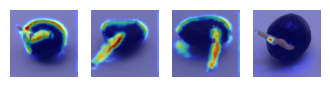

Grad-CAM for model.layer3


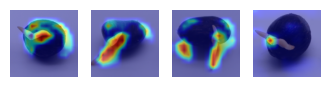

Grad-CAM for model.layer4


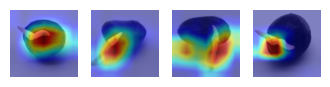

Validation Loss: 0.1007 | Validation Acc: 96.58% | Precision: 0.9778 | Recall: 0.9565 | F1 Score: 0.9670 | AUC: 0.9939

Illumination (Decrease brightness):
Original Images


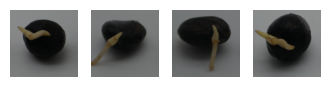

Grad-CAM for model.layer1


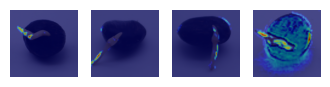

Grad-CAM for model.layer2


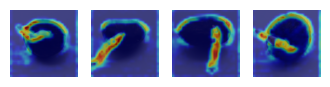

Grad-CAM for model.layer3


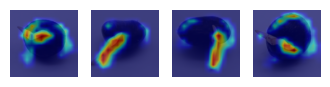

Grad-CAM for model.layer4


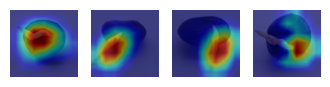

Validation Loss: 0.1574 | Validation Acc: 94.02% | Precision: 0.9095 | Recall: 0.9837 | F1 Score: 0.9452 | AUC: 0.9896

Noise:
Original Images


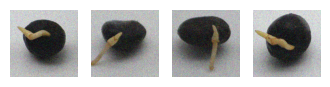

Grad-CAM for model.layer1


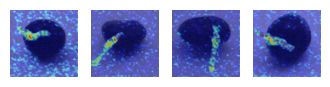

Grad-CAM for model.layer2


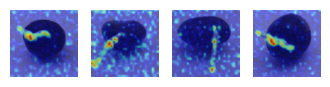

Grad-CAM for model.layer3


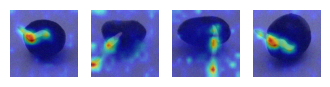

Grad-CAM for model.layer4


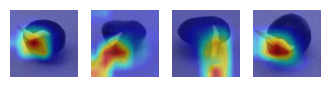

Validation Loss: 4.0829 | Validation Acc: 47.58% | Precision: 0.0000 | Recall: 0.0000 | F1 Score: 0.0000 | AUC: 0.7919



In [ ]:
# Load existing model
model = ResNet50Classifier(num_classes=2)
model.to(device)
checkpoint = torch.load('resnet50_baseline.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model_analysis(model, model_type="baseline") # Perform model analysis

# t-SNE plot showing how well the feature separates different classes (Existing Model)

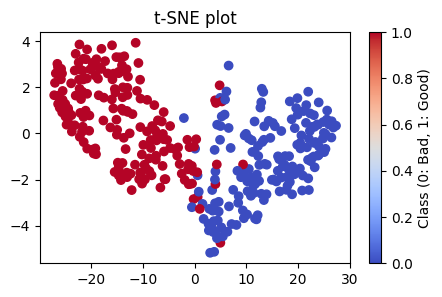

In [ ]:
model = ResNet50Classifier(num_classes=2)
model.to(device)
checkpoint = torch.load('resnet50_baseline.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
feature_discriminant(model, model_type="baseline")

# 9(f) Grad-CAM visualization of sample images in Batch-2 and Batch-3 (Existing Model)

Batch 2
Original Images


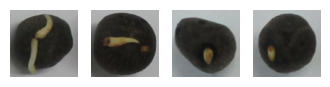

Grad-CAM for model.layer1


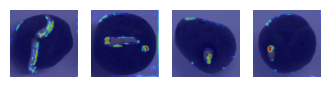

Grad-CAM for model.layer2


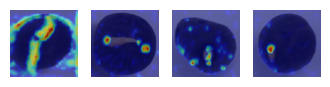

Grad-CAM for model.layer3


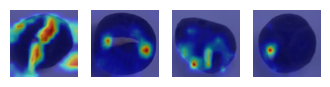

Grad-CAM for model.layer4


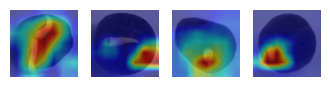

Batch 3
Original Images


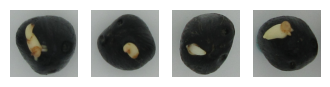

Grad-CAM for model.layer1


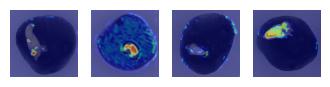

Grad-CAM for model.layer2


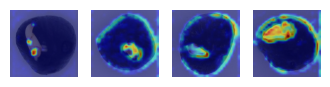

Grad-CAM for model.layer3


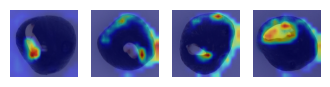

Grad-CAM for model.layer4


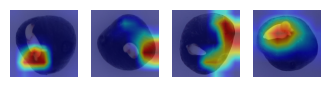

In [ ]:
model = ResNet50Classifier(num_classes=2)
model.to(device)
checkpoint = torch.load('resnet50_baseline.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
_, _, _, _, _, test_dataset1, test_dataset2 = getDataLoader("baseline") # Get Batch-2 and Batch-3 dataset
test_images1 = []
test_images2 = []
for i in range(4):
    image1, _ = test_dataset1[i+18]
    image2, _ = test_dataset2[i+14]
    test_images1.append(image1) # Get 4 sample images from Batch-2
    test_images2.append(image2) # Get 4 sample images from Batch-3
print("Batch 2")
display_gradcam(test_images1) # Display Grad-CAM for Batch-2 images
print("Batch 3")
display_gradcam(test_images2) # Display Grad-CAM for Batch-3 images

# (6) Train the proposed model (ResNet50 with CBAM + ViT)

In [ ]:
train_model(model_type="improved")

**********Training**********
Epoch 1/20 | Training Loss: 0.3711 | Validation Loss: 0.1719 | Training Acc: 81.37% | Validation Acc: 94.59% | Precision: 0.9460 | Recall: 0.9459 | F1 Score: 0.9459 | AUC: 0.9804
Best model saved at epoch 1 with F1 Score: 0.9459
Epoch 2/20 | Training Loss: 0.1242 | Validation Loss: 0.1243 | Training Acc: 95.50% | Validation Acc: 95.73% | Precision: 0.9590 | Recall: 0.9573 | F1 Score: 0.9572 | AUC: 0.9905
Best model saved at epoch 2 with F1 Score: 0.9572
Epoch 3/20 | Training Loss: 0.0481 | Validation Loss: 0.0871 | Training Acc: 98.57% | Validation Acc: 97.15% | Precision: 0.9716 | Recall: 0.9715 | F1 Score: 0.9715 | AUC: 0.9947
Best model saved at epoch 3 with F1 Score: 0.9715
Epoch 4/20 | Training Loss: 0.0285 | Validation Loss: 0.1405 | Training Acc: 99.21% | Validation Acc: 96.30% | Precision: 0.9649 | Recall: 0.9630 | F1 Score: 0.9630 | AUC: 0.9920
Epoch 5/20 | Training Loss: 0.0371 | Validation Loss: 0.0954 | Training Acc: 99.00% | Validation Acc: 97.

# Test the proposed model using Batch-2 and Batch-3

In [ ]:
test_model(batch=2, model_type="improved") # Test on Batch-2
test_model(batch=3, model_type="improved") # Test on Batch-3

**********Testing with Batch 2**********
Testing Loss: 0.28 | Testing Accuracy: 91.44% | Precision: 0.9167 | Recall: 0.9144 | F1 Score: 0.9143 | AUC: 0.9687
**********Testing with Batch 3**********
Testing Loss: 0.59 | Testing Accuracy: 83.22% | Precision: 0.8322 | Recall: 0.8322 | F1 Score: 0.8322 | AUC: 0.8990


# (7) Perform model analysis using the validation dataset in Batch-1 for the propsed model
Grad-CAM visualization showing the model's focus areas

No transformation:
Original Images


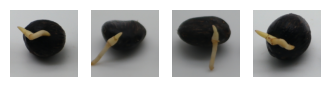

Grad-CAM for model.layer1


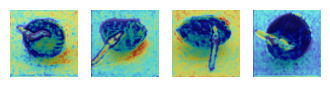

Grad-CAM for model.layer2


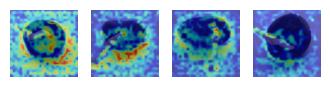

Grad-CAM for model.layer3


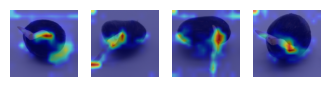

Grad-CAM for model.layer4


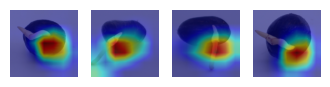

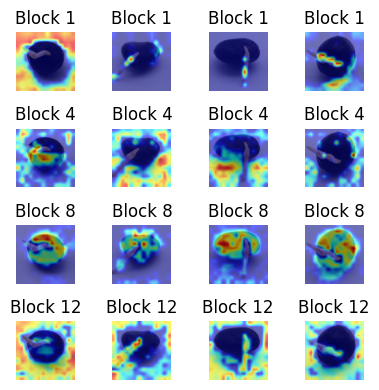

Validation Loss: 0.0756 | Validation Acc: 98.58% | Precision: 0.9891 | Recall: 0.9837 | F1 Score: 0.9864 | AUC: 0.9974

Translation:
Original Images


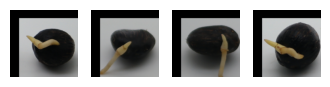

Grad-CAM for model.layer1


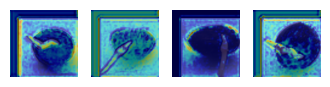

Grad-CAM for model.layer2


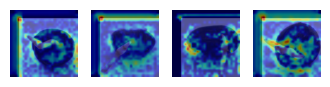

Grad-CAM for model.layer3


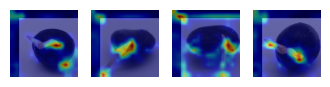

Grad-CAM for model.layer4


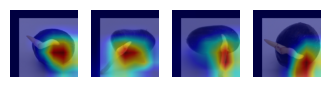

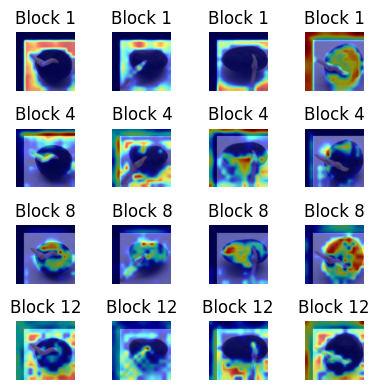

Validation Loss: 0.0771 | Validation Acc: 98.29% | Precision: 0.9890 | Recall: 0.9783 | F1 Score: 0.9836 | AUC: 0.9973

Rotation:
Original Images


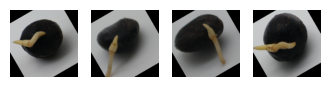

Grad-CAM for model.layer1


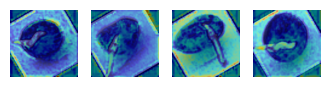

Grad-CAM for model.layer2


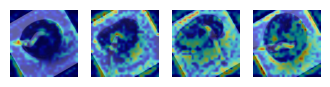

Grad-CAM for model.layer3


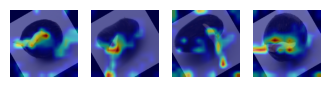

Grad-CAM for model.layer4


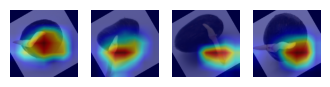

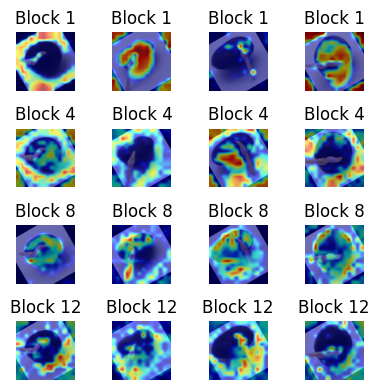

Validation Loss: 0.1360 | Validation Acc: 97.44% | Precision: 0.9944 | Recall: 0.9565 | F1 Score: 0.9751 | AUC: 0.9921

Scaling:
Original Images


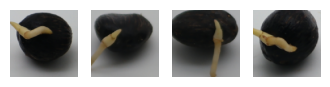

Grad-CAM for model.layer1


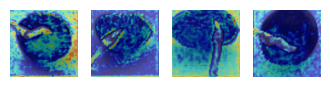

Grad-CAM for model.layer2


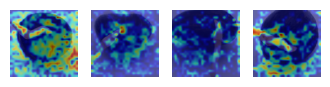

Grad-CAM for model.layer3


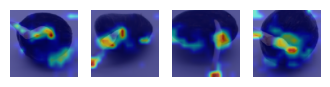

Grad-CAM for model.layer4


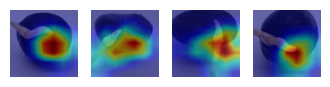

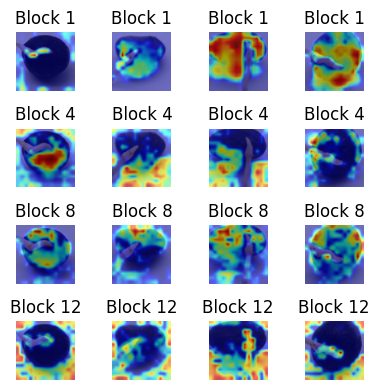

Validation Loss: 0.0687 | Validation Acc: 97.44% | Precision: 0.9888 | Recall: 0.9620 | F1 Score: 0.9752 | AUC: 0.9967

Illumination (Increase brightness):
Original Images


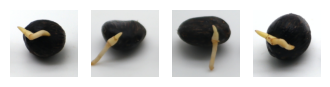

Grad-CAM for model.layer1


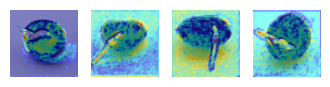

Grad-CAM for model.layer2


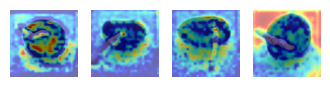

Grad-CAM for model.layer3


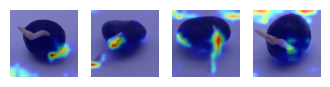

Grad-CAM for model.layer4


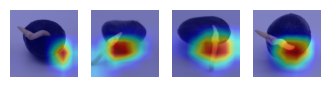

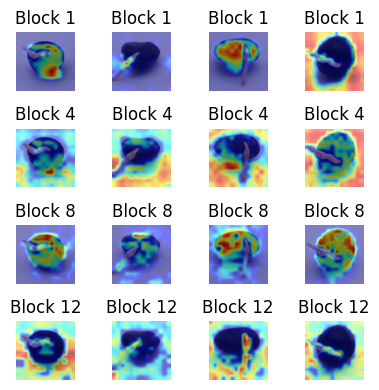

Validation Loss: 0.1353 | Validation Acc: 96.30% | Precision: 0.9831 | Recall: 0.9457 | F1 Score: 0.9640 | AUC: 0.9930

Illumination (Decrease brightness):
Original Images


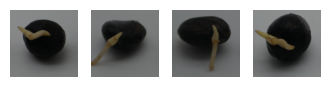

Grad-CAM for model.layer1


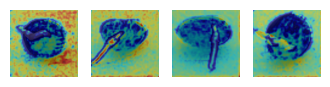

Grad-CAM for model.layer2


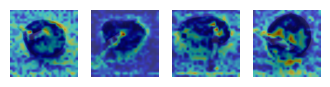

Grad-CAM for model.layer3


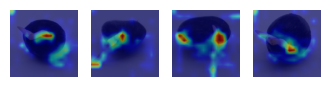

Grad-CAM for model.layer4


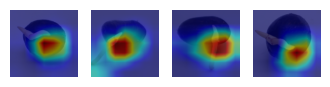

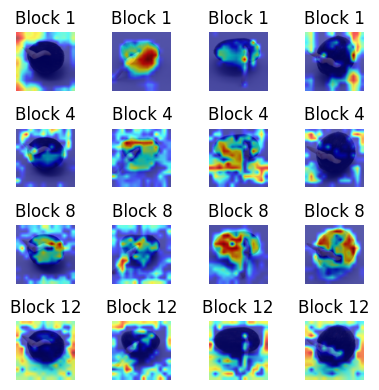

Validation Loss: 0.1143 | Validation Acc: 96.87% | Precision: 0.9529 | Recall: 0.9891 | F1 Score: 0.9707 | AUC: 0.9961

Noise:
Original Images


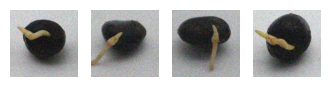

Grad-CAM for model.layer1


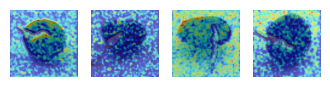

Grad-CAM for model.layer2


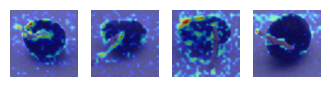

Grad-CAM for model.layer3


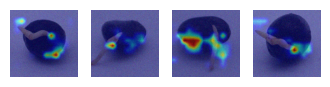

Grad-CAM for model.layer4


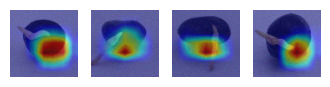

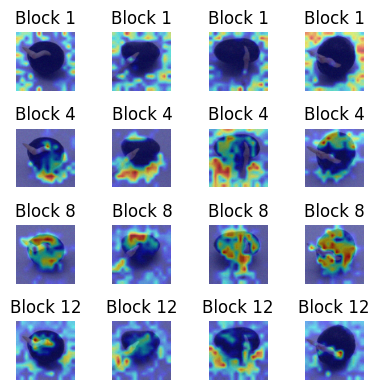

Validation Loss: 0.2731 | Validation Acc: 90.88% | Precision: 0.9190 | Recall: 0.9088 | F1 Score: 0.9079 | AUC: 0.9815



In [ ]:
model = ResNet50Improved(num_classes=2)
model.to(device)
checkpoint = torch.load('resnet50_improved.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model_analysis(model, model_type="improved") # Perform model analysis

# t-SNE plot showing how well the feature separates different classes (Proposed Model)

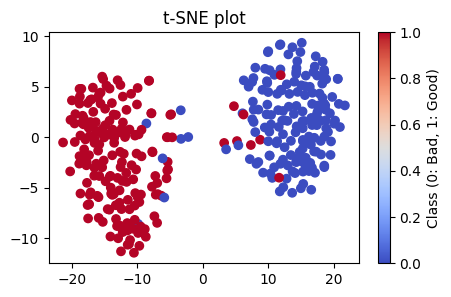

In [ ]:
model = ResNet50Improved(num_classes=2)
model.to(device)
checkpoint = torch.load('resnet50_improved.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
feature_discriminant(model, model_type="improved")

# 9(f) Grad-CAM visualization of sample images in Batch-2 and Batch-3 (Proposed Model)

Batch 2
Original Images


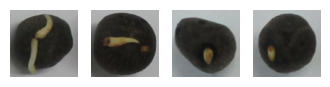

Grad-CAM for model.layer1


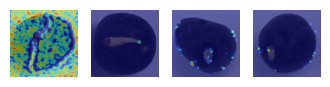

Grad-CAM for model.layer2


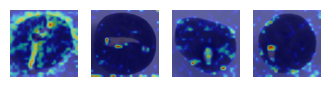

Grad-CAM for model.layer3


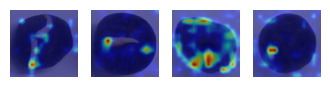

Grad-CAM for model.layer4


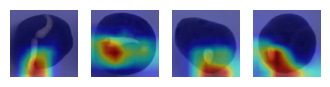

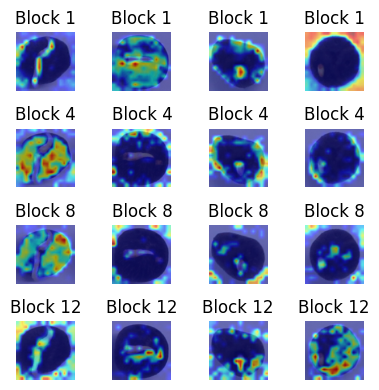

Batch 3
Original Images


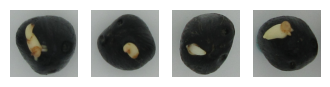

Grad-CAM for model.layer1


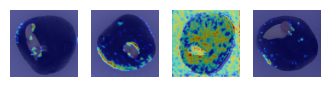

Grad-CAM for model.layer2


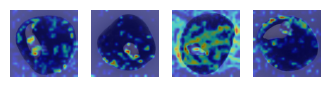

Grad-CAM for model.layer3


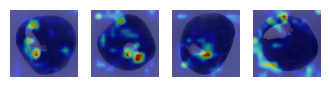

Grad-CAM for model.layer4


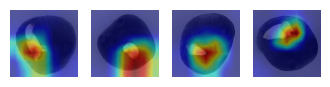

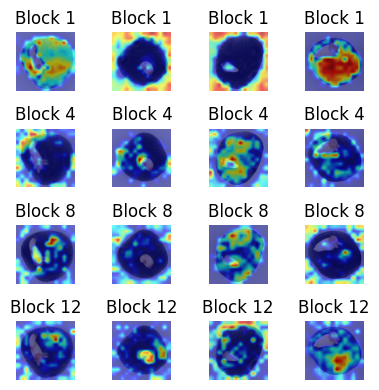

In [ ]:
model = ResNet50Improved(num_classes=2)
model.to(device)
checkpoint = torch.load('resnet50_improved.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
_, _, _, _, _, test_dataset1, test_dataset2 = getDataLoader("improved") # Get Batch-2 and Batch-3 dataset
test_images1 = []
test_images2 = []
for i in range(4):
    image1, _ = test_dataset1[i+18]
    image2, _ = test_dataset2[i+14]
    test_images1.append(image1) # Get 4 sample images from Batch-2
    test_images2.append(image2) # Get 4 sample images from Batch-3

print("Batch 2")
# Display Grad-CAM for Batch-2 images
display_gradcam(test_images1)
plot_vit_gradcam(test_images1)

print("Batch 3")
# Display Grad-CAM for Batch-3 images
display_gradcam(test_images2)
plot_vit_gradcam(test_images2)